# Power Spectrum wavefront map

In [1]:
import numpy as np
from numpy.random import RandomState
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt
import zern_core as zern

Let's begin by loading the pregenerated map containing 100 Zernike polynomials

In [2]:
# Parameters
N =1024
N_zern = 100
randgen = RandomState(12345)

coef = randgen.normal(size=N_zern)
print('First 10 Zernike coefficients')
print(coef[:10])

First 10 Zernike coefficients
[-0.20470766  0.47894334 -0.51943872 -0.5557303   1.96578057  1.39340583
  0.09290788  0.28174615  0.76902257  1.24643474]


Let's plot the wavefront map which comes in a flattened(1024 x 1024) array



 Mode: Jacobi
Total time required to evaluate 105 Zernike polynomials = 9.302 sec
Average time per polynomials: 88.590 ms


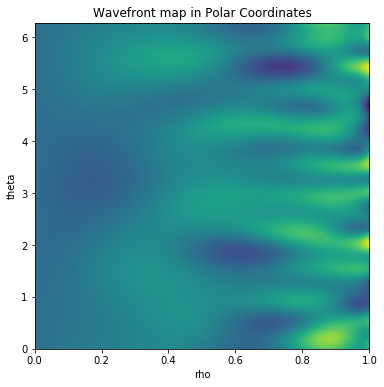

In [3]:
rho_1 = np.linspace(0.0, 1.0, N, endpoint=True)
theta_1 = np.linspace(0.0, 2*np.pi, N)

rr, tt = np.meshgrid(rho_1, theta_1)
rho, theta = rr.flatten(), tt.flatten()

z = zern.ZernikeNaive(mask=np.ones((N, N)))
phase = z(coef=coef, rho=rho, theta=theta, normalize_noll=False, mode='Jacobi', print_option=None)
phase_map = phase.reshape((N, N))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(phase_map, origin='lower', extent=[0, 1, 0, 2*np.pi])
ax.set_aspect('auto')
plt.xlabel('rho')
plt.ylabel('theta')
plt.title('Wavefront map in Polar Coordinates')
plt.show()

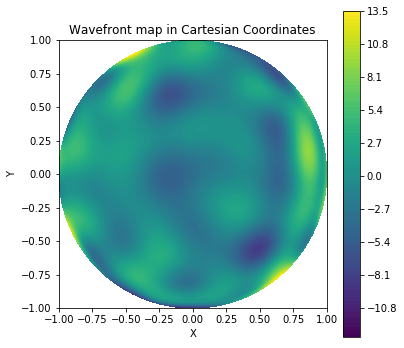

In [4]:
xx = rr * np.cos(tt)
yy = rr * np.sin(tt)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax1 = ax.contourf(xx, yy, phase_map, 100)
ax.set_aspect('equal')
plt.title('Wavefront map in Cartesian Coordinates')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(ax1)
plt.show()

## Power Spectral Density profiles

We will compute the PSD along the radial coordinate to get an idea of how power decreases with spatial frequency.
As expected for a wavefront map it roughly follows a power law $PSD \propto f^{-2}$

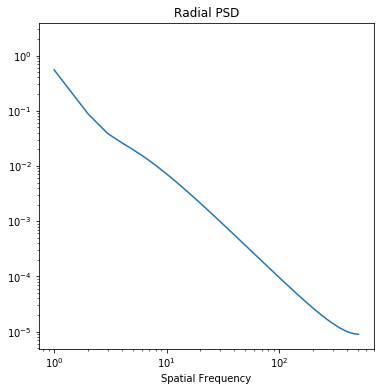

In [5]:
fft_r = 1./N * fft(phase_map[N//2,:])
PSD = fftshift((np.abs(fft_r))**2)

PSD_sym = PSD[N//2 + 1:]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.loglog(PSD_sym)
ax.set_xlabel('Spatial Frequency')
plt.title('Radial PSD')
plt.show()

## RMS wavefront error

So the PSD follows a standard power law such that higher spatial frequencies (high order Zernike polynomials) carry less power than low order aberrations like defocus or astigmatism.

But how does that translate into RMS wavefront error?

If we start substracting low order contributions from our wavefront, how does the residual RMS change? We would like to know where to cut our series expansion of Zernike polynomials such that the RMS is sufficiently low.

In [6]:
mean = np.mean(phase_map)
total_rms = np.sqrt(1./N**2 * np.sum((phase_map - mean)**2))

print('Initial RMS of the Wavefront: %.3f [waves]' %total_rms)

Initial RMS of the Wavefront: 2.587 [waves]


Let's load the Model Matrix of the Zernike coefficients. This is a matrix $H$ of shape ($N^2, N_{zern}$) for which the operation of computing a wavefront map boils down to:

$\begin{equation}
Z(\rho, \theta) = H \cdot a
\end{equation}$

Where $a$ is the vector of coefficients of the series expansion. In other words, $H$ contains the flattened versions of each of the base Zernike polynomials.

In [7]:
H = z.model_matrix
Z = H.shape[-1]
model_matrix = H.reshape((N, N, Z))

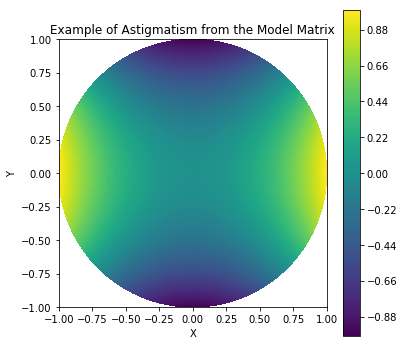

In [8]:
i = 5
zern = 1 * model_matrix[:, :, i]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax1 = ax.contourf(xx, yy, zern, 100)
ax.set_aspect('equal')
plt.title('Example of Astigmatism from the Model Matrix')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(ax1)
plt.show()

So we are going to compute the remaining RMS as we substract the Zernike polynomials one by one

In [9]:
def compute_rms(phase_array):
    
    mean = np.mean(phase_array)
    rms = np.sqrt(1./N**2 * np.sum((phase_array - mean)**2))
    
    return rms

In [10]:
RMS = []
maps = []
remaining = np.zeros((N, N))
max_phase = np.max(phase_map)
min_phase = np.min(phase_map)

for i in range(100):
    copy_phase = phase_map.copy()
    coef_zern = coef[:i+1]
    matrix = model_matrix[:,:,:i+1]
    phase_to_extract = np.dot(matrix, coef_zern)
    remaining = copy_phase - phase_to_extract
    RMS.append(compute_rms(remaining))
    
    if (np.mod(i, 20)==0):
        maps.append(remaining)

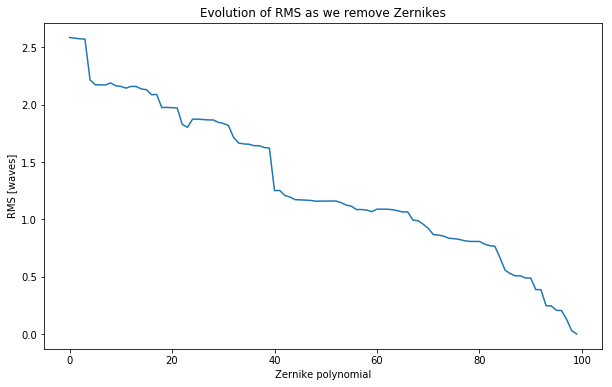

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(RMS)
plt.title('Evolution of RMS as we remove Zernikes')
plt.xlabel('Zernike polynomial')
plt.ylabel('RMS [waves]')
plt.show()

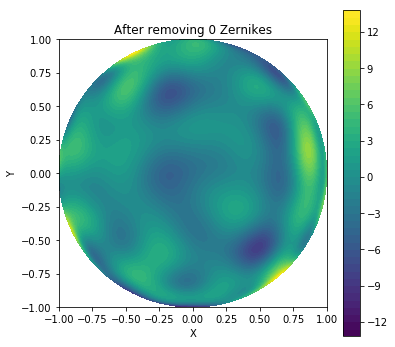

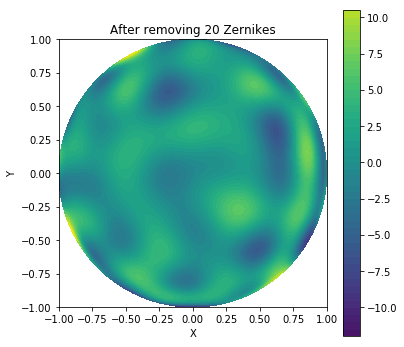

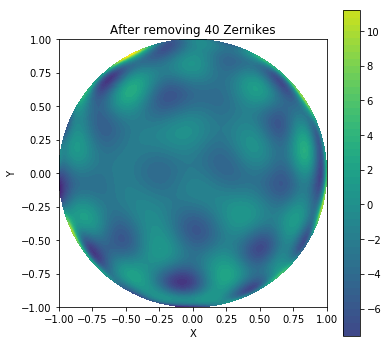

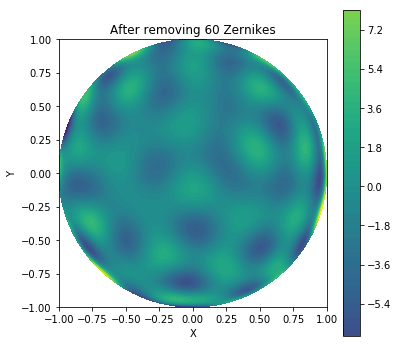

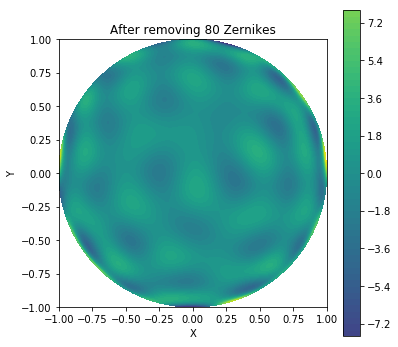

In [12]:
for i, phase_map in enumerate(maps):
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax1 = ax.contourf(xx, yy, phase_map, 50)
    ax.set_aspect('equal')
    plt.title('After removing %d Zernikes' %(20*i))
    plt.xlabel('X')
    plt.ylabel('Y')
    cbar = plt.colorbar(ax1)
    cbar.set_clim(min_phase, max_phase)

plt.show()

## Decay of Zernike coefficients

We have simply computed the coefficients of the series expansion with a random Gaussian array. In reality the values should decay (in waves) as we go to higher order.


In [13]:
def solve_triangular(Z):
    """ 
    Solves the equation of Triangular Numbers T_n
    T_n = n (n + 1) / 2
    for T_n = N_zern
    """
    
    n = int(0.5 * (-1 + np.sqrt(1 + 8*Z)))
    
    return n

def decay_factor(n, ratio=100):
    """
    Computes how much you need to rescale the coefficients
    at each Zernike row such that after "n" levels your magnitude
    has been reduced by a "ratio"
    """
    
    log_10_alfa = -np.log10(ratio)/(n-1)
    alfa = 10 ** (log_10_alfa)
    
    return alfa

def generate_decay_vector(n, decay_alfa):
    """
    Create a vector of length Z containing
    the required scaling 
    """
    vec = [1]
    for i in range(1, n):
        new_vec = [decay_alfa**i for _ in range(i+1)]
        vec.extend(new_vec)
    return np.array(vec)


In [14]:
n = solve_triangular(Z)
alfa = decay_factor(n)
v = generate_decay_vector(n, alfa)

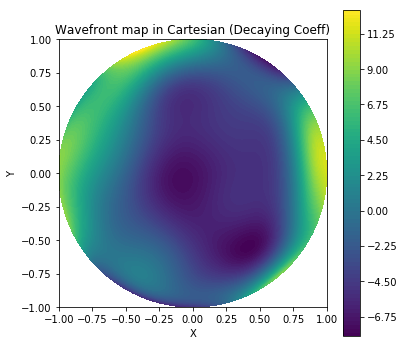

In [15]:
rescaled_coef = v[:N_zern] * coef
# Rescale them so that they have comparable PV to the original map
norm_unscaled = np.linalg.norm(coef)
norm_rescaled = np.linalg.norm(rescaled_coef)
rescaled_coef *= (norm_unscaled / norm_rescaled)

new_phase = np.dot(model_matrix[:,:,:N_zern], rescaled_coef)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax1 = ax.contourf(xx, yy, new_phase, 100)
ax.set_aspect('equal')
plt.title('Wavefront map in Cartesian (Decaying Coeff)')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(ax1)
plt.show()

We can see that if the coefficients decay as we progress through the Zernike rows, the overall shape of the phase map appears to be dominated by low order polynomials. In contrast, the original map had more high frequency features.

But how will this affect the PSD?

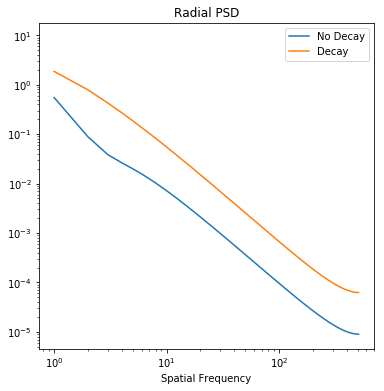

In [16]:
fft_resc = 1./N * fft(new_phase[N//2,:])
PSD_resc = fftshift((np.abs(fft_resc))**2)

PSD_resc = PSD_resc[N//2 + 1:]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.loglog(PSD_sym, label='No Decay')
ax.loglog(PSD_resc, label='Decay')
ax.set_xlabel('Spatial Frequency')
plt.legend()
plt.title('Radial PSD')
plt.show()

In principle this does not affect the overall distribution of power, as we can see that the slope is essentially the same for both cases. But does it affect the evolution of RMS as we remove the polynomials?

In [17]:
RMS_decay = []
remaining = np.zeros((N, N))
max_phase = np.max(new_phase)
min_phase = np.min(new_phase)

for i in range(100):
    copy_phase = new_phase.copy()
    coef_zern = rescaled_coef[:i+1]
    matrix = model_matrix[:,:,:i+1]
    phase_to_extract = np.dot(matrix, coef_zern)
    remaining = copy_phase - phase_to_extract
    RMS_decay.append(compute_rms(remaining))

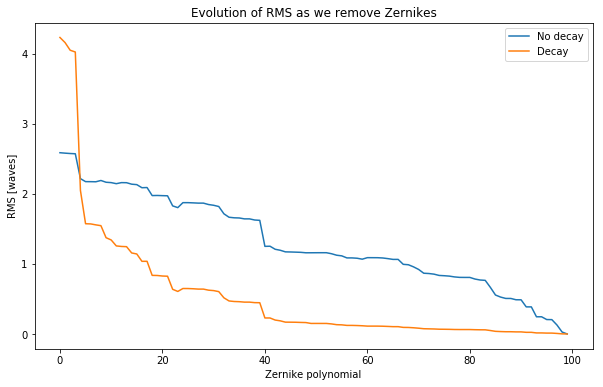

In [18]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(RMS, label='No decay')
ax.plot(RMS_decay, label='Decay')
plt.title('Evolution of RMS as we remove Zernikes')
plt.xlabel('Zernike polynomial')
plt.ylabel('RMS [waves]')
plt.legend()
plt.show()